# Análise de Sentimentos dos Tweets sobre as Eleições Brasileiras de 2022
## T2 - Inteligência Artificial

### Grupo:
- Thiago Macedo
- Vitor Pires
- Lorenzo Lazzarotto
- Pedro Nunes

### 1. Import das Bibliotecas Necessárias

In [36]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import re 
import matplotlib.pyplot as plt
import seaborn as sns

sns.color_palette("icefire", as_cmap=True)
nltk.download(['punkt', 'wordnet', 'stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/thiagomacedo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Leitura dos Dados

In [5]:
df = pd.read_csv('tweets.csv')
df.head()

,author_id,created_at,id,lang,retweet_count,text,sinal
0,"1,46E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,45,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,"1,51E+18",2022-08-08T01:08:23Z,"1,56E+18",pt,0,Periga o Argenta chamar o Simon pra responder ...,NaN
2,"1,06E+18",2022-08-08T01:08:21Z,"1,56E+18",pt,14,RT @WinstonLing Segue o link para assistirem o...,1.0
3,"7,15E+17",2022-08-08T01:08:20Z,"1,56E+18",pt,88,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,1455004730,2022-08-08T01:08:20Z,"1,56E+18",pt,0,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   author_id      3000 non-null   object 
 1   created_at     3000 non-null   object 
 2   id             3000 non-null   object 
 3   lang           3000 non-null   object 
 4   retweet_count  3000 non-null   int64  
 5   text           3000 non-null   object 
 6   sinal          1372 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 164.2+ KB


### 3. Limpeza dos Dados

#### 3.1 Removendo colunas desnecessárias

In [7]:
df = df.drop(columns=['author_id', 'created_at', 'id', 'lang', 'retweet_count'])
df.head()

,text,sinal
0,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,Periga o Argenta chamar o Simon pra responder ...,NaN
2,RT @WinstonLing Segue o link para assistirem o...,1.0
3,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


As colunas `author_id`, `created_at`, `id`, `lang` e `retweet_count` não são necessárias para o modelo, pois toda a informação vem do texto do tweet. 

#### 3.2 Renomeando as colunas `text` e `sinal`

In [8]:
df = df.rename(columns={'text': 'tweet', 'sinal': 'sentiment'})
df.head()

,tweet,sentiment
0,RT @EdegarPretto O meu candidato vice-governad...,1.0
1,Periga o Argenta chamar o Simon pra responder ...,NaN
2,RT @WinstonLing Segue o link para assistirem o...,1.0
3,RT @EdegarPretto Eu quero dizer aos gaúchos e ...,NaN
4,@wmfigueiredo @evertonvf @bandrs @EduardoLeite...,0.0


A coluna `text` contém o texto to tweet, e a coluna `sinal` contém a codificação do sentimento (0 negativo e 1 positivo)

#### 3.3 Tratando os valores faltantes

In [9]:
df.isnull().sum()

tweet           0
sentiment    1628
dtype: int64

O dataset possui 1628 linhas onde não há um sentimento especificado.

**Removendo os valores faltantes**

In [10]:
df = df.dropna()
df.shape

(1372, 2)

Sem os valores faltantes, o dataset passou a ter 1372 linhas (todas completas).

#### 3.4 Tratando os valores duplicados

In [11]:
df.duplicated().sum()

253

O dataset contém 253 linhas repetidas.
- as linhas repetidas provavelmente surgem de RTs a outros tweets.

**Removendo os valores repetidos (geram bias no modelo)**

In [12]:
df = df.drop_duplicates()
df.shape

(1119, 2)

Sem os valores repetidos o dataset passou a ter 1119 linhas diferentes e sem valores faltantes.

#### 3.5 Tratando os tipos de dados

In [13]:
df['sentiment'] = df['sentiment'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119 entries, 0 to 2949
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      1119 non-null   object
 1   sentiment  1119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.2+ KB


### 4. Análise dos Dados

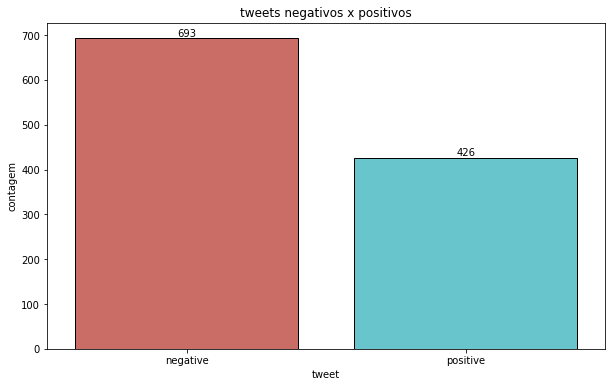

In [14]:
df2 = df.groupby('sentiment').count()
df2 = df2.reset_index()
df2['sentiment'] = df2['sentiment'].apply(lambda x: 'negative' if x==0 else 'positive')

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df2, x='sentiment', y='tweet', palette='hls', edgecolor='black')
ax.set_title('tweets negativos x positivos')
ax.set_ylabel('contagem')
ax.set_xlabel('tweet')

for i in ax.containers:
    ax.bar_label(i, size=10)

plt.show()

Como podemos ver no gráfico, existem mais tweets considerados negativos do dataset (653), em comparação com os tweets positivos (426). Esse desbalanceamento pode afetar a performance do modelo e gerar um bias. O ideal é ter uma quantidade igual de exemplos de cada tipo. 

### 5. Engenharia de Features e Modelagem

#### 5.1 Pipeline de Feature Engineering

A engenharia de features será feita através de um conjunto de mátodos que irão gerar informações úteis para o modelo. A pipeline segue a seguinte ordem:
1. Transforma todo o texto para minúsculo
2. Remove todo tipo de caractere que não seja uma letra to alfabeto ou um número
3. Performa tokenização (com a função da biblioteca `nltk`)
4. Performa lematização (com a função da biblioteca `nltk`)
5. Remove as `stop_words` (com a função da biblioteca `nltk`)

Essa função retorna o texto do tweet processado e padronizado. 

In [15]:
def tokenize(text):
    # make all text lowercase 
    text = text.lower()

    # remove all type of punctuations 
    text = re.sub(f'[^a-z0-9]',' ', text)

    # tokenize the text
    tokens = word_tokenize(text)

    # lemmatize the text
    tokens = [WordNetLemmatizer().lemmatize(w) for w in tokens]

    # remove stopwords
    tokens = [w for w in tokens if w not in stopwords.words('portuguese')]
    
    return tokens

#### 5.2 Função para apresentação dos resultados do modelo

In [16]:
def plot_results(y_test, y_pred):
    # matrix de confusão
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", cmap="icefire")
    plt.show()
    
    # métricas da classificação 
    target_names = ['negative', 'positive']
    print(classification_report(y_test, y_pred, target_names = target_names))

#### 5.3 Separação dos dados em treino e teste 
- Utilizando a função `train_test_split` do `sklearn`

In [17]:
X = df['tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

X_train.shape, X_test.shape

((895,), (224,))

#### 5.4 Pipeline de Machine Learning com o Algoritmo KNN

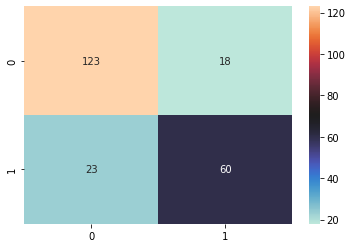

              precision    recall  f1-score   support

    negative       0.84      0.87      0.86       141
    positive       0.77      0.72      0.75        83

    accuracy                           0.82       224
   macro avg       0.81      0.80      0.80       224
weighted avg       0.82      0.82      0.82       224



In [18]:
pipeline_knn = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('knn', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)
y_pred = pipeline_knn.predict(X_test)
plot_results(y_test, y_pred)

O KNN conseguiu um resultado bem satisfatório, com **0.82 de F1 Score**

#### 5.5 Pipeline de Machine Learning com o Algoritmo MultiLayer Perceptron

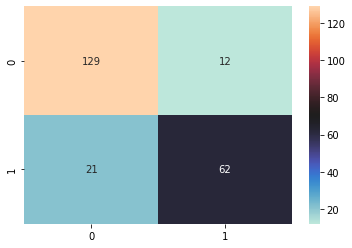

              precision    recall  f1-score   support

    negative       0.86      0.91      0.89       141
    positive       0.84      0.75      0.79        83

    accuracy                           0.85       224
   macro avg       0.85      0.83      0.84       224
weighted avg       0.85      0.85      0.85       224



In [30]:
pipeline_mlp = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('mlp', MLPClassifier())
])

pipeline_mlp.fit(X_train, y_train)
y_pred = pipeline_mlp.predict(X_test)
plot_results(y_test, y_pred)

O MultiLayer Perceptron conseguiu um resultado muito bom, com **0.85 de F1 Score**

#### 5.6 Pipeline de Machine Learning com o Algoritmo XGBoost

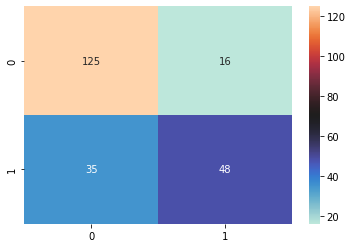

              precision    recall  f1-score   support

    negative       0.78      0.89      0.83       141
    positive       0.75      0.58      0.65        83

    accuracy                           0.77       224
   macro avg       0.77      0.73      0.74       224
weighted avg       0.77      0.77      0.76       224



In [20]:
pipeline_xgb = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('xgb', XGBClassifier())
])

pipeline_xgb.fit(X_train, y_train)
y_pred = pipeline_xgb.predict(X_test)
plot_results(y_test, y_pred)

O XGBoost conseguiu um resultado bem ruin, com **0.76 de F1 Score**

#### 5.7 Pipeline de Machine Learning com o Algoritmo AdaBoost

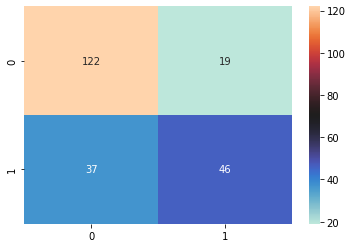

              precision    recall  f1-score   support

    negative       0.77      0.87      0.81       141
    positive       0.71      0.55      0.62        83

    accuracy                           0.75       224
   macro avg       0.74      0.71      0.72       224
weighted avg       0.75      0.75      0.74       224



In [21]:
pipeline_ada = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('ada', AdaBoostClassifier())
])

pipeline_ada.fit(X_train, y_train)
y_pred = pipeline_ada.predict(X_test)
plot_results(y_test, y_pred)

O Adaboost conseguiu um resultado bem ruim, com **0.74 de F1 Score**

#### 5.8 Pipeline de Machine Learning com o algoritmo Naive Bayes

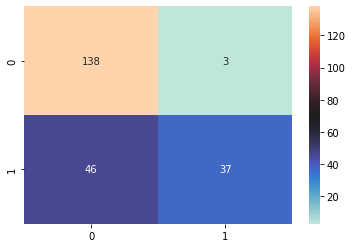

              precision    recall  f1-score   support

    negative       0.75      0.98      0.85       141
    positive       0.93      0.45      0.60        83

    accuracy                           0.78       224
   macro avg       0.84      0.71      0.73       224
weighted avg       0.81      0.78      0.76       224



In [22]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('nb', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred = pipeline_nb.predict(X_test)
plot_results(y_test, y_pred)

O Naive Bayes também conseguiu um resultado bem ruim, com **0.76 de F1 Score**

#### 5.9 Pipeline de Machine Learning com o algoritmo Support Vector Machine

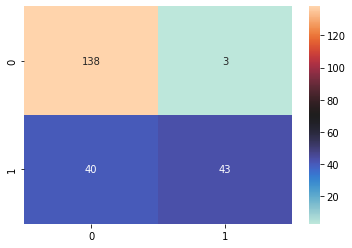

              precision    recall  f1-score   support

    negative       0.78      0.98      0.87       141
    positive       0.93      0.52      0.67        83

    accuracy                           0.81       224
   macro avg       0.86      0.75      0.77       224
weighted avg       0.83      0.81      0.79       224



In [23]:
pipeline_sv = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('sv', SVC())
])

pipeline_sv.fit(X_train, y_train)
y_pred = pipeline_sv.predict(X_test)
plot_results(y_test, y_pred)

O Adaboost conseguiu um resultado aceitável, com **0.79 de F1 Score**

#### 5.10 Pipeline de Machine Learning com o algoritmo Random Forest

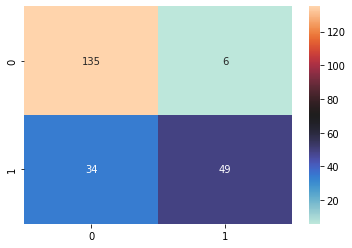

              precision    recall  f1-score   support

    negative       0.80      0.96      0.87       141
    positive       0.89      0.59      0.71        83

    accuracy                           0.82       224
   macro avg       0.84      0.77      0.79       224
weighted avg       0.83      0.82      0.81       224



In [28]:
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('rf', RandomForestClassifier())
])

pipeline_rf.fit(X_train, y_train)
y_pred = pipeline_rf.predict(X_test)
plot_results(y_test, y_pred)

O Adaboost conseguiu um resultado bom, com **0.81 de F1 Score**

#### 5.11 Pipeline de Machine Learning com o algoritmo Regressão Logística

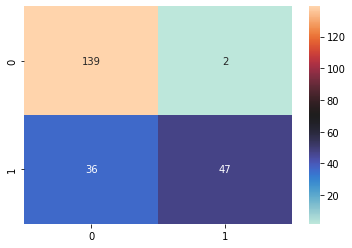

              precision    recall  f1-score   support

    negative       0.79      0.99      0.88       141
    positive       0.96      0.57      0.71        83

    accuracy                           0.83       224
   macro avg       0.88      0.78      0.80       224
weighted avg       0.86      0.83      0.82       224



In [31]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('lr', LogisticRegression())
])

pipeline_lr.fit(X_train, y_train)
y_pred = pipeline_lr.predict(X_test)
plot_results(y_test, y_pred)

A regressão logística conseguiu um resultado bem bom, com **0.82 de F1 Score**

Podemos ver que o melhor algoritmo foi o  `Multilayer Perceptron`, com **0.85 de F1 Score**. Logo, vou salvá-lo em um arquivo pickle.

In [35]:
pickle.dump(pipeline_mlp, open('neural_network.pkl', 'wb'))

### 6. Juntando vários modelos 

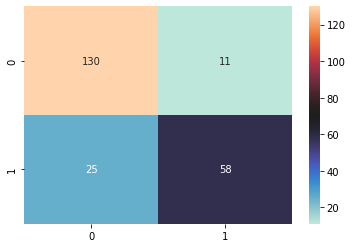

              precision    recall  f1-score   support

    negative       0.84      0.92      0.88       141
    positive       0.84      0.70      0.76        83

    accuracy                           0.84       224
   macro avg       0.84      0.81      0.82       224
weighted avg       0.84      0.84      0.84       224



In [39]:
estimators = [
    ('mlp', MLPClassifier()),
    ('lr', LogisticRegression()),
    ('knn', KNeighborsClassifier())
]

pipeline_stack = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('stack', StackingClassifier(estimators=estimators))
])

pipeline_stack.fit(X_train, y_train)
y_pred = pipeline_stack.predict(X_test)
plot_results(y_test, y_pred)

Infelizmente, a junção dos melhores modelos **não** melhorou os resultados, obtendo **0.84 de F1 Score**.

O projeto também pode ser encontrado no GitHub aqui: https://github.com/macedoti13/Election-Tweets-Sentiment-Analysis